<a href="https://www.kaggle.com/code/gaskilla/notebook24f6ebcc57?scriptVersionId=216703146" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # work with regular expressions
import category_encoders as ce
from sklearn import preprocessing
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova
from scipy.stats import normaltest

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import ast
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kagg

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv
/kaggle/input/countries-of-the-world/countries of the world.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [3]:
DATA_DIR = '/kaggle/input/sf-booking/'
dftrain = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
dftest = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [4]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
dftrain['sample'] = 1 # помечаем где у нас трейн
dftest['sample'] = 0 # помечаем где у нас тест
dftest['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

df = pd.concat([dftrain, dftest], ignore_index = True) # объединяем

Для начала удалим дубликаты из тренировочных данных

In [5]:
print(f'Количество строк в датафрейм = {dftrain.shape[0]}')
print(f' Количество строк без дубликатов = {dftrain.drop_duplicates().shape[0]}')
dftrain = dftrain.drop_duplicates()

Количество строк в датафрейм = 386803
 Количество строк без дубликатов = 386496


Чтобы признаки обрабатывались корректно обьединим тест и трейн в один сет

# **Дальше посмотрим на каждый признак в наших данных и подумаем что мы можем из него извлечь**

# Сразу преобазуем признак Days since review в числовой формат

In [6]:
df['days_since_review'] = df['days_since_review'].apply(lambda x: int(x.split()[0]))

# Из review_date можно выделить месяц года и год в котором посетитель был в отеле

In [7]:
df['review_date'] = df['review_date'].astype('datetime64[ms]')
df['review_month'] = df['review_date'].dt.month
df['review_year'] = df['review_date'].dt.year
df.drop(['review_date'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

# Видим пропуски в координатах отелей, попробуем найти координаты в интернете, используя поиск по названиям отеля вручную

In [8]:
empty = df[df['lat'].isna()]
empty.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3268 entries, 122 to 515616
Data columns (total 19 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   hotel_address                               3268 non-null   object 
 1   additional_number_of_scoring                3268 non-null   int64  
 2   average_score                               3268 non-null   float64
 3   hotel_name                                  3268 non-null   object 
 4   reviewer_nationality                        3268 non-null   object 
 5   negative_review                             3268 non-null   object 
 6   review_total_negative_word_counts           3268 non-null   int64  
 7   total_number_of_reviews                     3268 non-null   int64  
 8   positive_review                             3268 non-null   object 
 9   review_total_positive_word_counts           3268 non-null   int64  
 10  total_number_

In [9]:
print(empty['hotel_name'].unique())

['Austria Trend Hotel Schloss Wilhelminenberg Wien'
 'Holiday Inn Paris Montmartre' 'Fleming s Selection Hotel Wien City'
 'Hotel Atlanta' 'Maison Albar Hotel Paris Op ra Diamond'
 'Derag Livinghotel Kaiser Franz Joseph Vienna' 'Hotel City Central'
 'NH Collection Barcelona Podium' 'City Hotel Deutschmeister'
 'Hotel Daniel Vienna' 'Roomz Vienna' 'Hotel Pension Baron am Schottentor'
 'Mercure Paris Gare Montparnasse' 'Hotel Park Villa' 'Hotel Advance'
 'Renaissance Barcelona Hotel' 'Cordial Theaterhotel Wien']


In [10]:
missed_hotels = pd.DataFrame({'hotel_name':['Austria Trend Hotel Schloss Wilhelminenberg Wien',
'Holiday Inn Paris Montmartre', 'Fleming s Selection Hotel Wien City',
'Hotel Atlanta', 'Maison Albar Hotel Paris Op ra Diamond',
'Derag Livinghotel Kaiser Franz Joseph Vienna', 'Hotel City Central',
'NH Collection Barcelona Podium', 'City Hotel Deutschmeister',
'Hotel Daniel Vienna', 'Roomz Vienna', 'Hotel Pension Baron am Schottentor',
'Mercure Paris Gare Montparnasse', 'Hotel Park Villa', 'Hotel Advance',
'Renaissance Barcelona Hotel', 'Cordial Theaterhotel Wien'], 
'lat':[48.229047, 48.888945, 48.897508, 48.220819, 48.877885, 48.246288, 48.213632, 48.214636, 48.222147, 48.188816, 48.222970, 48.216753, 48.838038, 46.991676, 28.103670, 41.392437, 48.209565], 
'lng':[16.284445, 2.333260, 2.207706, 16.356070, 2.324035, 16.341359, 16.379934, 16.380054, 16.366343, 16.383355, 16.393311, 16.359726, 2.318824, 3.154911, 113.013415, 2.167519, 16.351598] })



In [11]:
for _, row in missed_hotels.iterrows():
    # Находим строки с совпадающим названием отеля
    mask = df['hotel_name'] == row['hotel_name']
    
    # Обновляем координаты в основном DataFrame
    df.loc[mask, 'lat'] = row['lat']
    df.loc[mask, 'lng'] = row['lng']

# Проверяем результат
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

# Как мы можем видеть, пропуски заполнены .Далее обработаем признак hotel_adress

Добавим датафрейм с списком стран мира для дальнейшей работы

In [12]:
df_countries = pd.read_csv('/kaggle/input/countries-of-the-world/countries of the world.csv')


Извлечем признаки 'country' и 'city'   из адреса отеля  

In [13]:
countrylist = df_countries['Country'].tolist()
# В списке в конце строк с именами стран проставлены пробелы, они будут мешать нормальной работе модели, избавимся от них
countrylist = [country.strip() for country in countrylist]
df_countries['Country'] = df_countries['Country'].str.strip()


In [14]:
#Функция для поиска страны в адресе
def find_country(address, countrylist):
    words = address.split()
    for word in words:
        for country in countrylist:
            if country.lower() in address.lower():
                return country
    return None  # Если страна не найдена

In [15]:
# Название города указано в предпоследнем слове адреса (искл. - города Великобритании)
def get_city(address):
    city = address.split()[-2]
    if city=='United':
        city = address.split()[-5]
    return city
df['city'] = df['hotel_address'].apply(get_city)

In [16]:
#Применяем функцию к нашему датасету и создаем новый признак
df['Country'] = df['hotel_address'].apply(lambda x: find_country(x, countrylist))
df['Country'].unique()
df

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,reviewer_score,tags,days_since_review,lat,lng,sample,review_month,review_year,city,Country
0,Stratton Street Mayfair Westminster Borough Lo...,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,...,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531,51.507894,-0.143671,1,2,2016,London,United Kingdom
1,130 134 Southampton Row Camden London WC1B 5AF...,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,...,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203,51.521009,-0.123097,1,1,2017,London,United Kingdom
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,...,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289,48.845377,2.325643,1,10,2016,Paris,France
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,...,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681,48.888697,2.394540,1,9,2015,Paris,France
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,...,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516,52.385601,4.847060,1,3,2016,Amsterdam,Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,Viale Monza 132 Distretto Viale Monza 20127 Mi...,53,8.1,Best Western Antares Hotel Concorde,Greece,No Negative,0,984,nice breakfast,4,...,0.0,"[' Business trip ', ' Couple ', ' Double Room ...",547,45.502453,9.221836,0,2,2016,Milan,Italy
515734,Duc De Medinaceli 8 Ciutat Vella 08002 Barcelo...,46,7.8,Medinaceli,United States of America,No Negative,0,523,Beautiful historic hotel in great location in...,24,...,0.0,"[' Leisure trip ', ' Couple ', ' Double Room '...",411,41.378169,2.178663,0,6,2016,Barcelona,Spain
515735,Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...,260,8.0,Suite Hotel 900 m zur Oper,New Zealand,No coffee in complimentary coffee in the room...,31,3461,The size of the room the courtyard and the lo...,23,...,0.0,"[' Business trip ', ' Solo traveler ', ' Singl...",28,48.193523,16.366915,0,7,2017,Vienna,Austria
515736,Corso Concordia 1 Milan City Center 20129 Mila...,159,9.0,Ch teau Monfort Relais Ch teaux,Australia,No Negative,0,1053,Staff very polite and helpful Hotel well loca...,20,...,0.0,"[' Leisure trip ', ' Solo traveler ', ' Execut...",586,45.468236,9.207380,0,12,2015,Milan,Italy


Text(0.5, 1.0, 'Страны и города отелей')

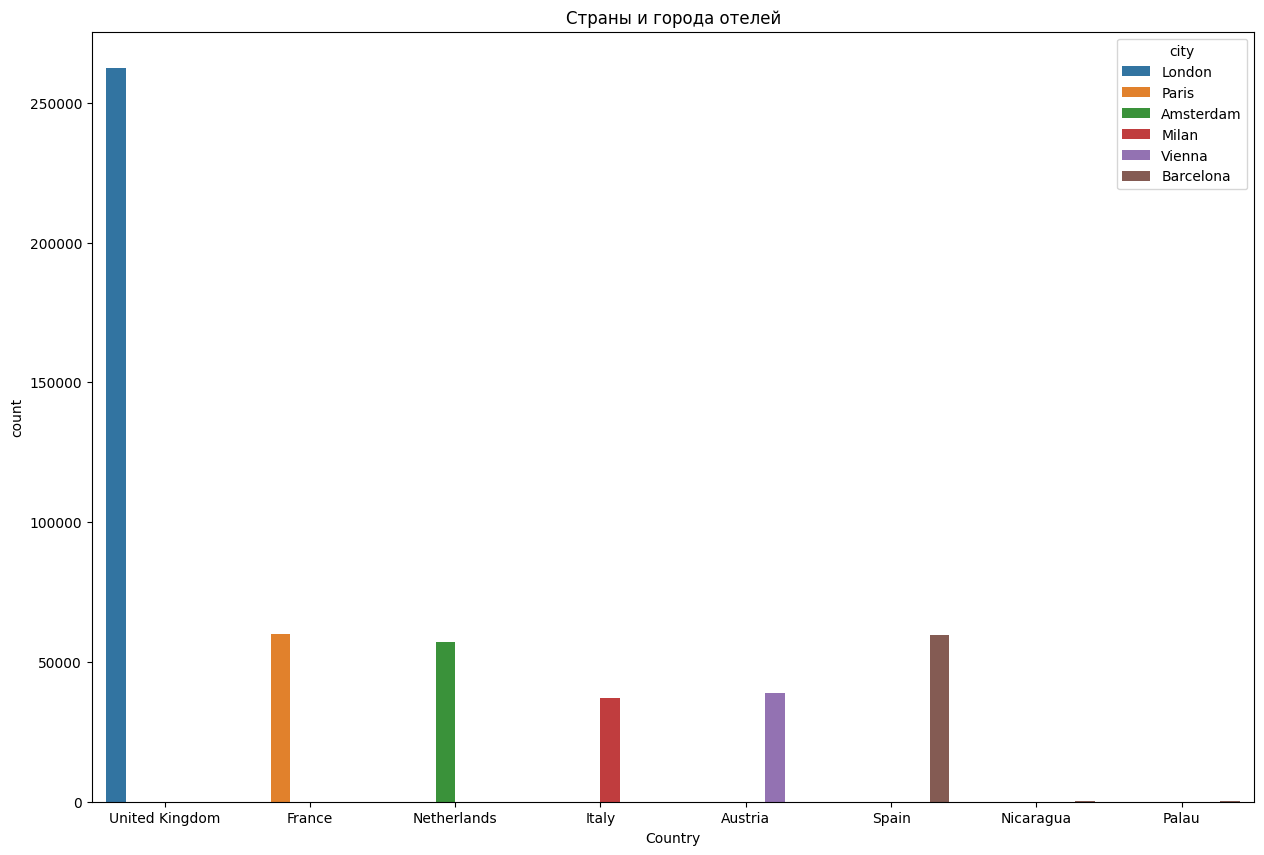

In [17]:
plt.figure(figsize=(15,10))
countplot = sns.countplot(data=df,x='Country',hue='city')
countplot.set_title('Страны и города отелей')

Мы видим что преимущественно в нашем датасете 6 стран и 6 городов, но есть малюсенькие столбцы Nicaragua и Palau, которые являются лишними выбросами скорее, мы их удалим.
Скорее всего они взялись при формировании признака 'Country', так как мы использовали для работы список стран мира, видимо некоторые отели были названы в честь этих стран


In [18]:
df = df[~df['Country'].isin(['Nicaragua', 'Palau'])]

Text(0.5, 1.0, 'Страны и города отелей')

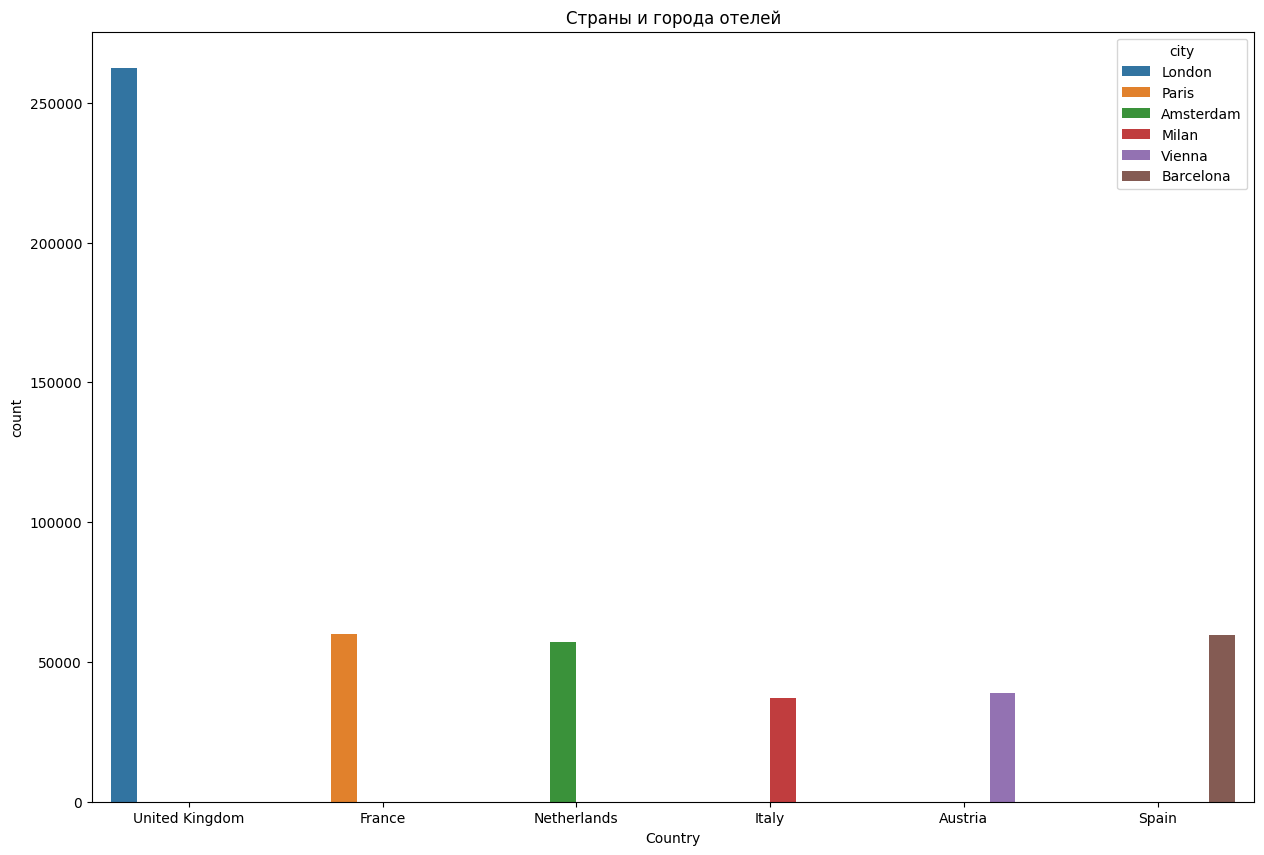

In [19]:
plt.figure(figsize=(15,10))
countplot = sns.countplot(data=df,x='Country',hue='city')
countplot.set_title('Страны и города отелей')


так как и стран и городов 6 - значит по городу на каждую страну, закодируем города через one hot кодирование и удалим колонны 'Country' и 'hotel_address', так как мы достали из них все что могли

In [20]:
# one-hot кодирование
df = pd.get_dummies(df, columns=['city'])
# удаление столбцов
df = df.drop(columns=['Country','hotel_address', 'hotel_name'])
df.head

<bound method NDFrame.head of         additional_number_of_scoring  average_score  \
0                                581            8.4   
1                                299            8.3   
2                                 32            8.9   
3                                 34            7.5   
4                                914            8.5   
...                              ...            ...   
515733                            53            8.1   
515734                            46            7.8   
515735                           260            8.0   
515736                           159            9.0   
515737                           297            8.0   

              reviewer_nationality  \
0                  United Kingdom    
1                  United Kingdom    
2                           China    
3                  United Kingdom    
4                          Poland    
...                            ...   
515733                     Greece    
51573

# Изучим теги



In [21]:
df['tags']

0         [' Leisure trip ', ' Couple ', ' Studio Suite ...
1         [' Business trip ', ' Couple ', ' Standard Dou...
2         [' Leisure trip ', ' Solo traveler ', ' Modern...
3         [' Leisure trip ', ' Solo traveler ', ' Standa...
4         [' Business trip ', ' Couple ', ' Standard Dou...
                                ...                        
515733    [' Business trip ', ' Couple ', ' Double Room ...
515734    [' Leisure trip ', ' Couple ', ' Double Room '...
515735    [' Business trip ', ' Solo traveler ', ' Singl...
515736    [' Leisure trip ', ' Solo traveler ', ' Execut...
515737    [' Leisure trip ', ' Couple ', ' Standard Room...
Name: tags, Length: 515092, dtype: object

Мы видим что наши теги содержатся в списках, но по сути являются строками, преобразуем их в списки

In [22]:
def safe_literal_eval(x):
    if isinstance(x, str):
        try:
            return [tag.strip() for tag in ast.literal_eval(x)]
        except (ValueError, SyntaxError):
            return []
    return []

df['tags'] = df['tags'].apply(safe_literal_eval)

# Проверим, сколько строк содержат теги
print(df['tags'].apply(len).value_counts())

tags
5    297435
4    211310
3      5501
6       755
2        85
1         6
Name: count, dtype: int64


In [23]:

unique_tags = set(tag for tags_list in df['tags'] for tag in tags_list)
#unique_tags

Закодируем теги по разным признаками

In [24]:
def tags(x):
    lst1 = {'Leisure trip' : 1, 'Business trip' : 2}
    lst2 = {'Couple' : 1, 'Solo traveler' : 2, 'Family with young children' : 4, 
             'Group' : 3, 'Family with older children' : 5, 'Travelers with friends' : 6}
    lst3 = {'Submitted from a mobile device' : 1}
    lst4 = {'With a pet' : 1}
    lst5 = {'Stayed' : re.findall(r'(\d+)(?!.*\d)', str(x))}
    def circle(x, lst):
        for i in lst:
            if i in x:
                x.remove(i)
                return lst[i]
            if i in str(x):
                index = [ind for ind in range(len(x)) if x[ind].startswith('Stayed')][0]
                x.remove(x[index])
                return lst[i][0]
        return 0  
    trip_kind = circle(x, lst1)
    travelers = circle(x, lst2)
    submitted  = circle(x, lst3)
    with_a_pet = circle(x, lst4)
    nights = circle(x, lst5)
    
    return trip_kind, travelers , submitted, with_a_pet, nights
 
df[['trip_kind', 'travelers', 'submitted', 'with_a_pet', 'nights']] = df['tags'].apply(tags).to_list()
df[['trip_kind', 'travelers', 'submitted', 'with_a_pet', 'nights']] = df[['trip_kind', 'travelers', 'submitted', 'with_a_pet', 'nights']].astype('int8')
print(df['travelers'])

0         1
1         1
2         2
3         2
4         1
         ..
515733    1
515734    1
515735    2
515736    2
515737    1
Name: travelers, Length: 515092, dtype: int8


Тэги закодированы, значит мы можем удалить столбец tags

In [25]:
df.drop(columns = 'tags')
df.head()

,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,...,city_Barcelona,city_London,city_Milan,city_Paris,city_Vienna,trip_kind,travelers,submitted,with_a_pet,nights
0,581,8.4,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,...,False,True,False,False,False,1,1,1,0,2
1,299,8.3,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,...,False,True,False,False,False,2,1,0,0,1
2,32,8.9,China,No kettle in room,6,406,No Positive,0,14,7.5,...,False,False,False,True,False,1,2,1,0,3
3,34,7.5,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,...,False,False,False,True,False,1,2,0,0,1
4,914,8.5,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,...,False,False,False,False,False,2,1,0,0,6


Взглянем на графики по каждому из полученных нами из тегов признаков отдельно

Text(0.5, 1.0, 'Цель поездки')

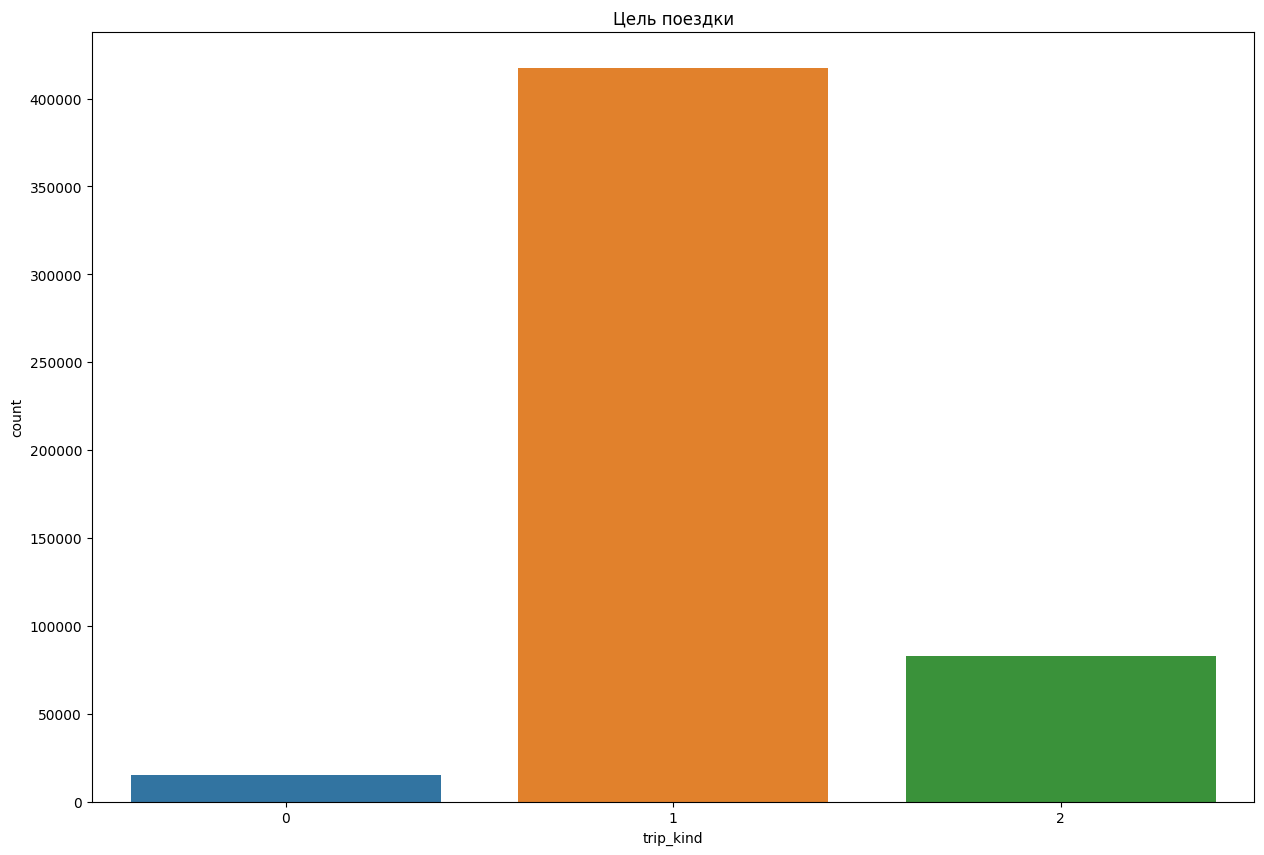

In [26]:
#trip_kind
plt.figure(figsize=(15,10))
countplot = sns.countplot(data=df,x='trip_kind')
countplot.set_title('Цель поездки')

Мы кодировали  так : lst1 = {'Leisure trip' : 1, 'Business trip' : 2}, 0 - другое. Естественно больше всего броней было сделано в целях отдыха, мало какие профессии требуют поездок в коммандировки и снятия отеля

Text(0.5, 1.0, 'Цель поездки')

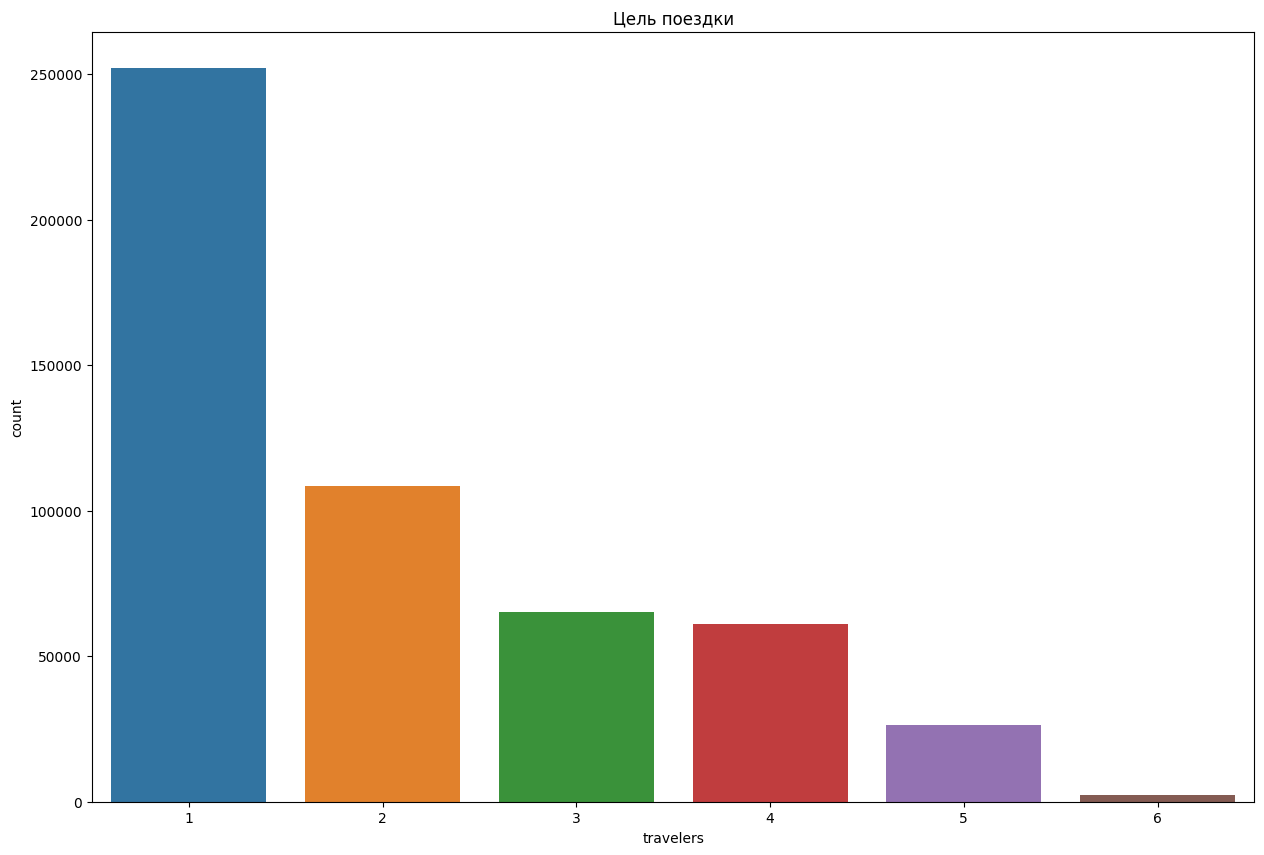

In [27]:
#'travelers'
plt.figure(figsize=(15,10))
countplot = sns.countplot(data=df,x='travelers')
countplot.set_title('Цель поездки')

мы кодировали так:     lst2 = {'Couple' : 1, 'Solo traveler' : 2, 'Family with young children' : 4, 'Group' : 3, 'Family with older children' : 5, 'Travelers with friends' : 6}, следовательно - график показывает что чаще всего снимали отель парочки, на втором месте соло путешественники что вполне естественно, ведь людям с семьями как правило сложнее бросить рутину и отправится в путешествие

Text(0.5, 1.0, 'Количество ночей')

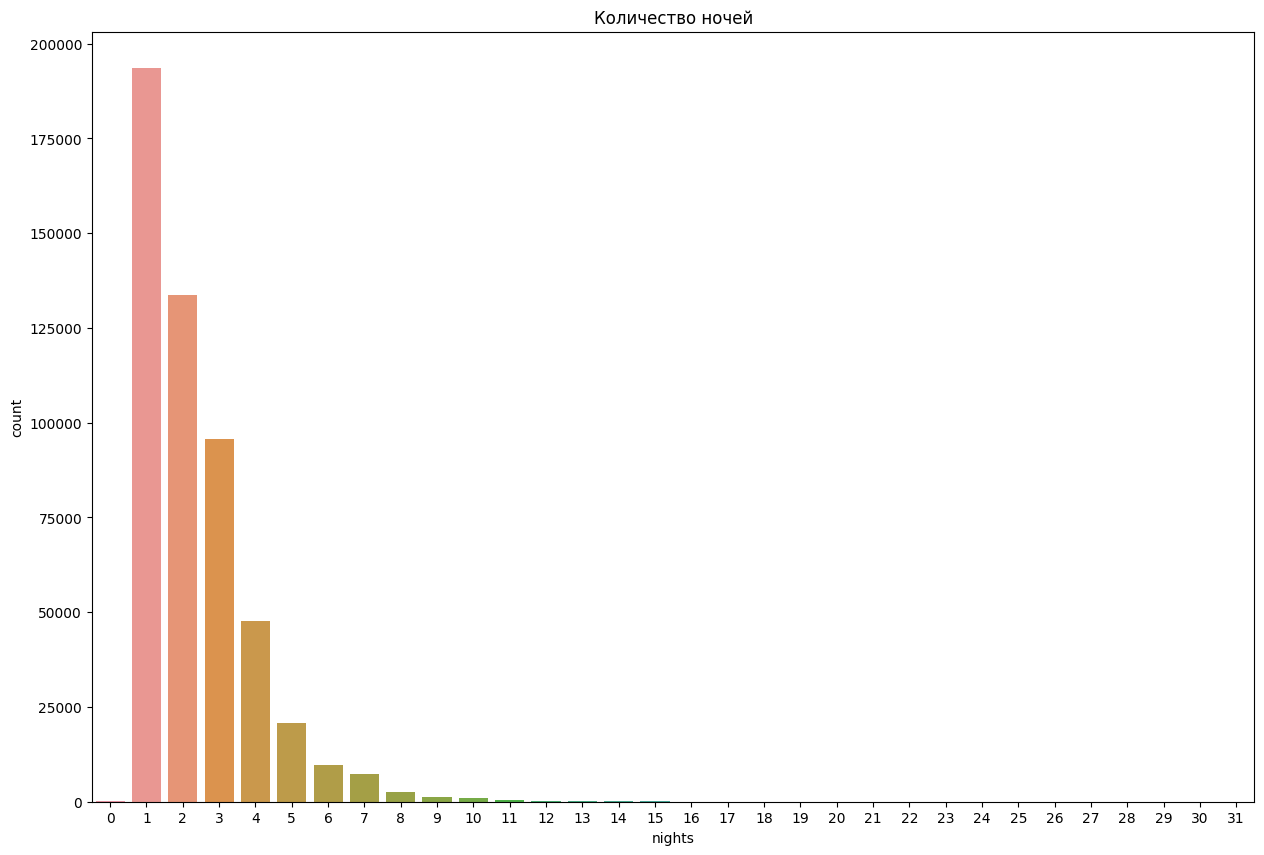

In [28]:
#nights
plt.figure(figsize=(15,10))
countplot = sns.countplot(data=df,x='nights')
countplot.set_title('Количество ночей')

In [29]:
print('Travelers with a pet',round(df['with_a_pet'].mean()*100,3),' %')

Travelers with a pet 0.273  %


In [30]:
print('Submitted from a mobile device',round(df['submitted'].mean()*100,3),' %')

Submitted from a mobile device 59.649  %


# Так же закодируем столбец reviewer_nationality

In [31]:
# one-hot кодирование
#df = pd.get_dummies(df, columns=['reviewer_nationality'])
# удаление столбцов
#df = df.drop(columns=['reviewer_nationality'])
df.head

<bound method NDFrame.head of         additional_number_of_scoring  average_score  \
0                                581            8.4   
1                                299            8.3   
2                                 32            8.9   
3                                 34            7.5   
4                                914            8.5   
...                              ...            ...   
515733                            53            8.1   
515734                            46            7.8   
515735                           260            8.0   
515736                           159            9.0   
515737                           297            8.0   

              reviewer_nationality  \
0                  United Kingdom    
1                  United Kingdom    
2                           China    
3                  United Kingdom    
4                          Poland    
...                            ...   
515733                     Greece    
51573

# Мы могли бы еще проанализировать комментарии, сформировать группы на основе отзывов и закодировать их, но мы делаем учебную модель, так что не будем пока углубляться и  перейдем к анализу значимости признаков

<Axes: >

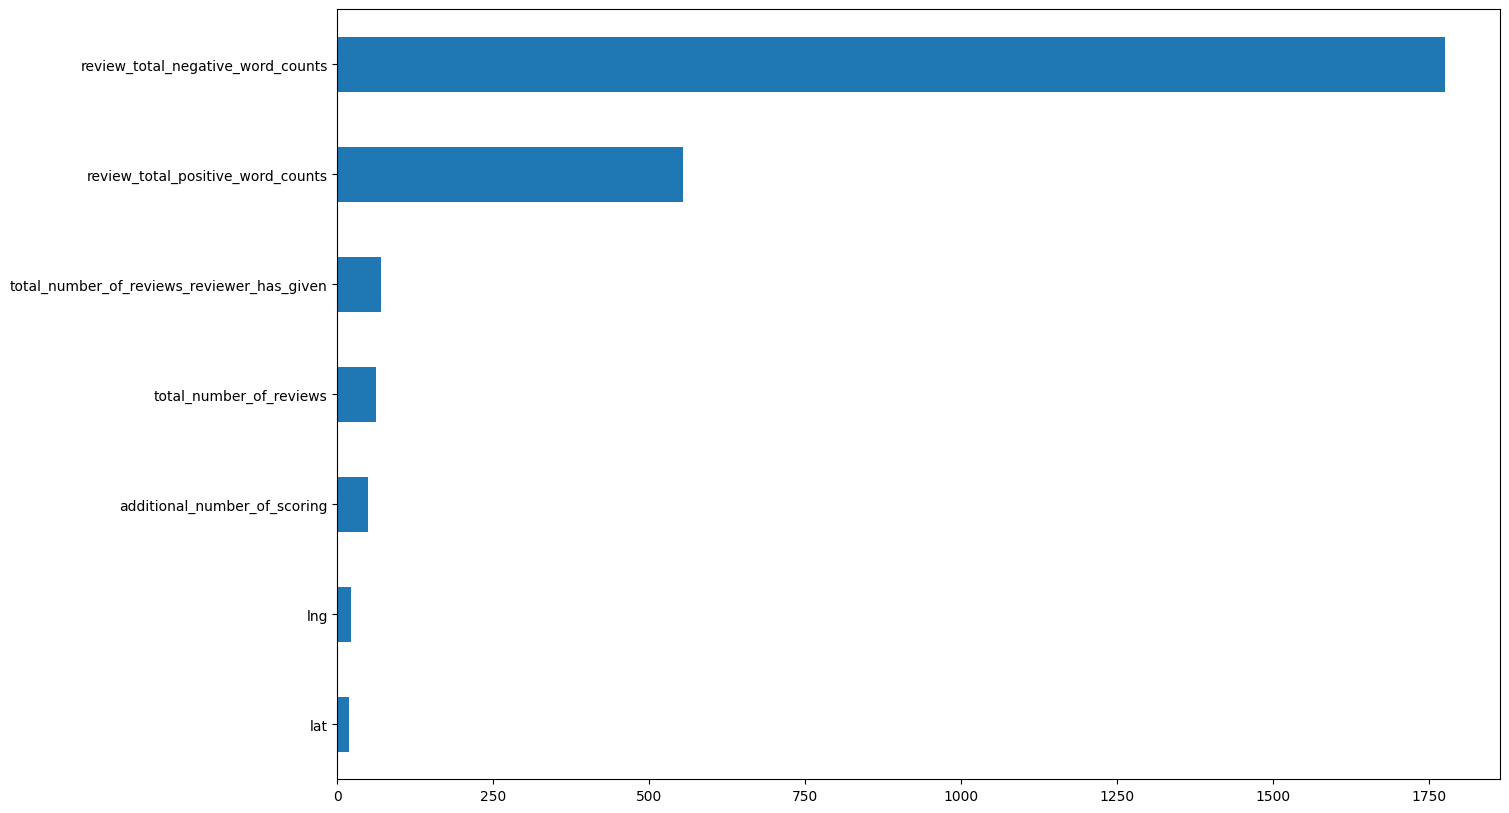

In [32]:
# непрерывные признаки
num_cols = ['total_number_of_reviews',
            'review_total_negative_word_counts',
            'additional_number_of_scoring',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given',
            'lat',
            'lng']
plt.figure(figsize=(15,10))
imp_num = pd.Series(f_classif(df[num_cols], df['reviewer_score'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [33]:
df = df.select_dtypes(exclude=['object'])

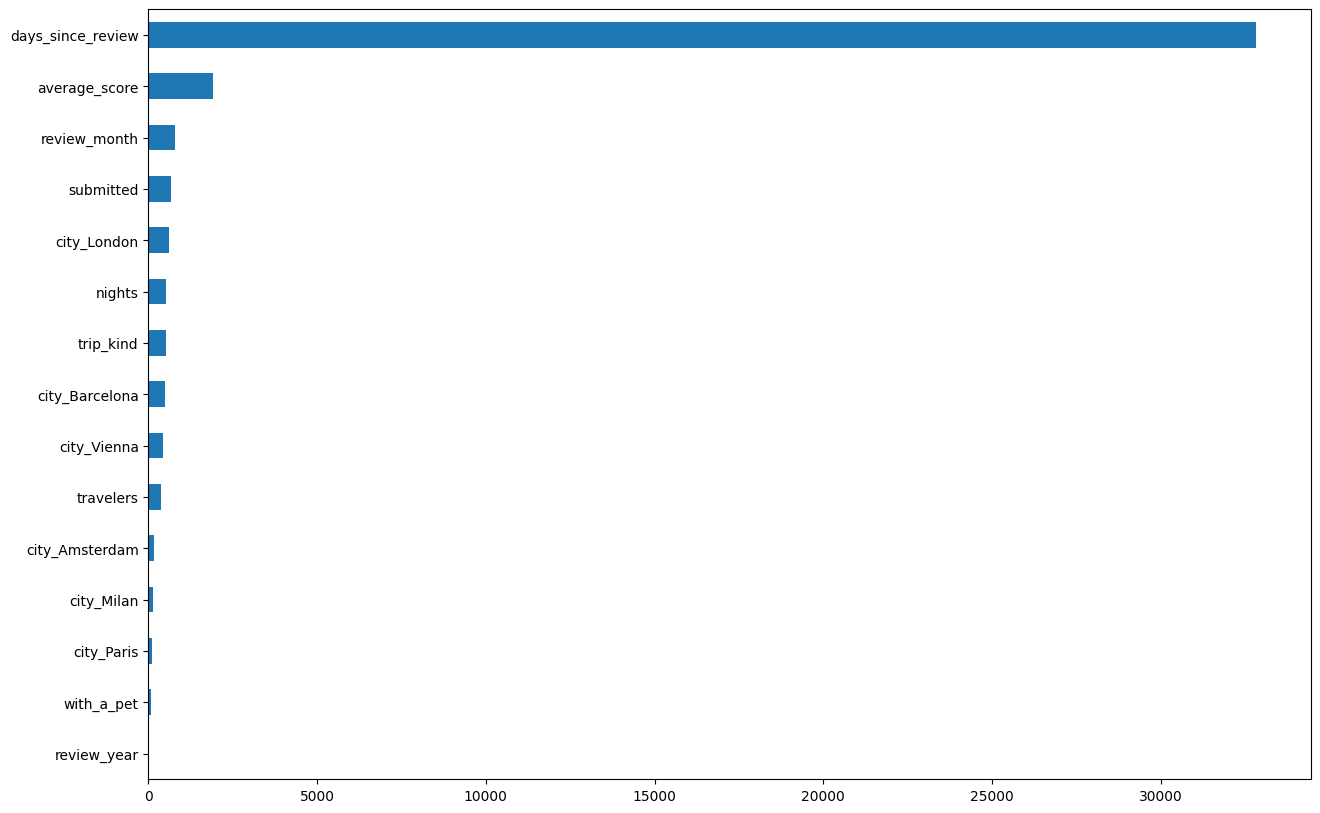

In [34]:
# кодирование переменной "reviewer_score" для проведения корреляционного теста
#print('Число уникальных значений: ',data['reviewer_score'].nunique())
ord_encoder = ce.OrdinalEncoder()
df['reviewer_score_coding'] =  ord_encoder.fit_transform(df[['reviewer_score']].sort_values(by='reviewer_score').astype(str))
#display(df[['reviewer_score','reviewer_score_coding']].tail(15))
#df = df.drop(columns=['average_score'])
mask = df['sample']==1
y = df[mask]['reviewer_score_coding']
# категориальные признаки
add_cols = ['reviewer_score','sample','reviewer_score_coding']
cols_list = num_cols.copy()
cols_list.extend(add_cols)
cat_cols = [s for s in df.columns if s not in cols_list]
#cat_cols
plt.figure(figsize=(15,10))
imp_cat = pd.Series(chi2(df[mask][cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
df = df.drop(columns=['reviewer_score_coding'])

p=0.000
Данные не распределены нормально (мы отвергаем H0)


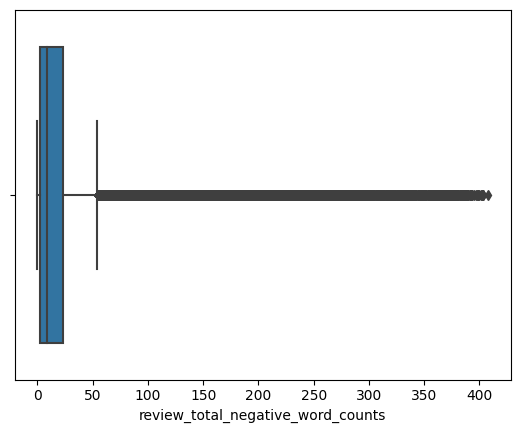

In [35]:
sns.boxplot(data=df,x='review_total_negative_word_counts')
_, p = normaltest(df['review_total_negative_word_counts'])
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
print('p=%.3f' % p)
alpha = 0.05
# Интерпретация 
if p > alpha/2:
    print(H0)
else:
    print(Ha)

In [36]:
# Нормализация признака
r_scaler = preprocessing.RobustScaler()
df['review_total_positive_word_counts'] = r_scaler.fit_transform(df[['review_total_positive_word_counts']])

# Стандартизация признака
s_scaler = preprocessing.StandardScaler()
df['review_total_positive_word_counts'] = s_scaler.fit_transform(df[['review_total_positive_word_counts']])

# Отбор признаков

<Axes: >

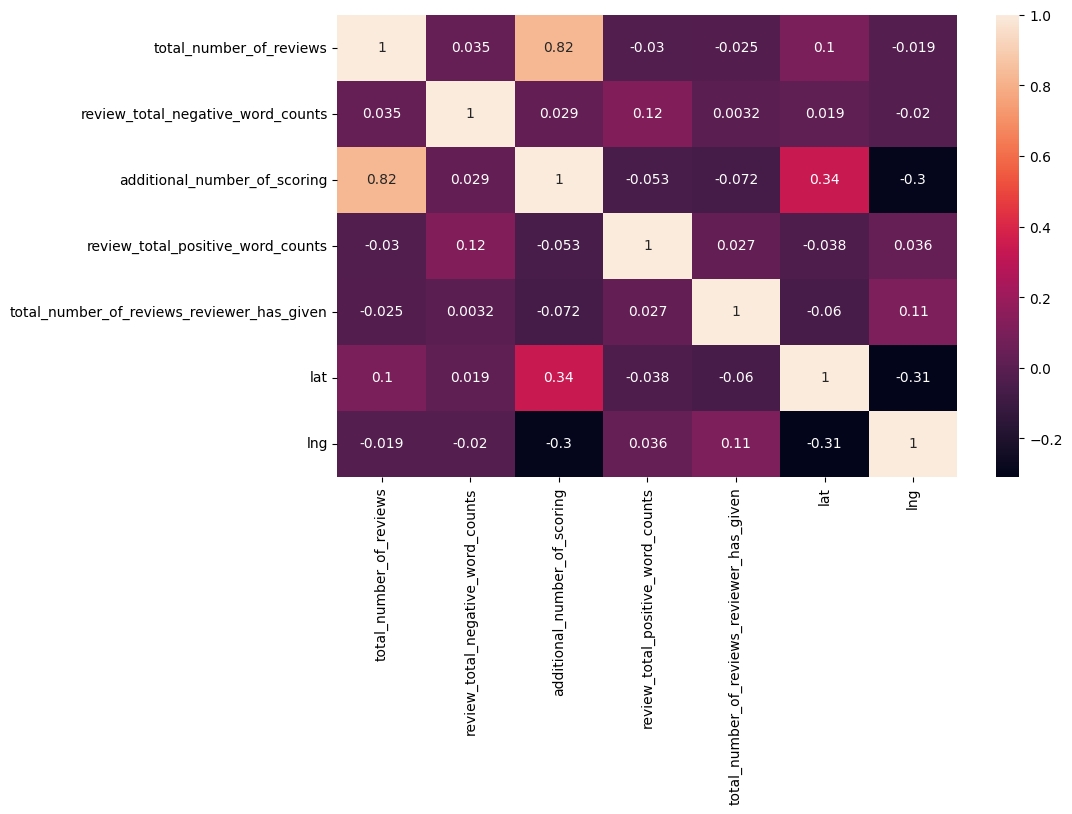

In [37]:
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(method='pearson'),annot=True)

<Axes: >

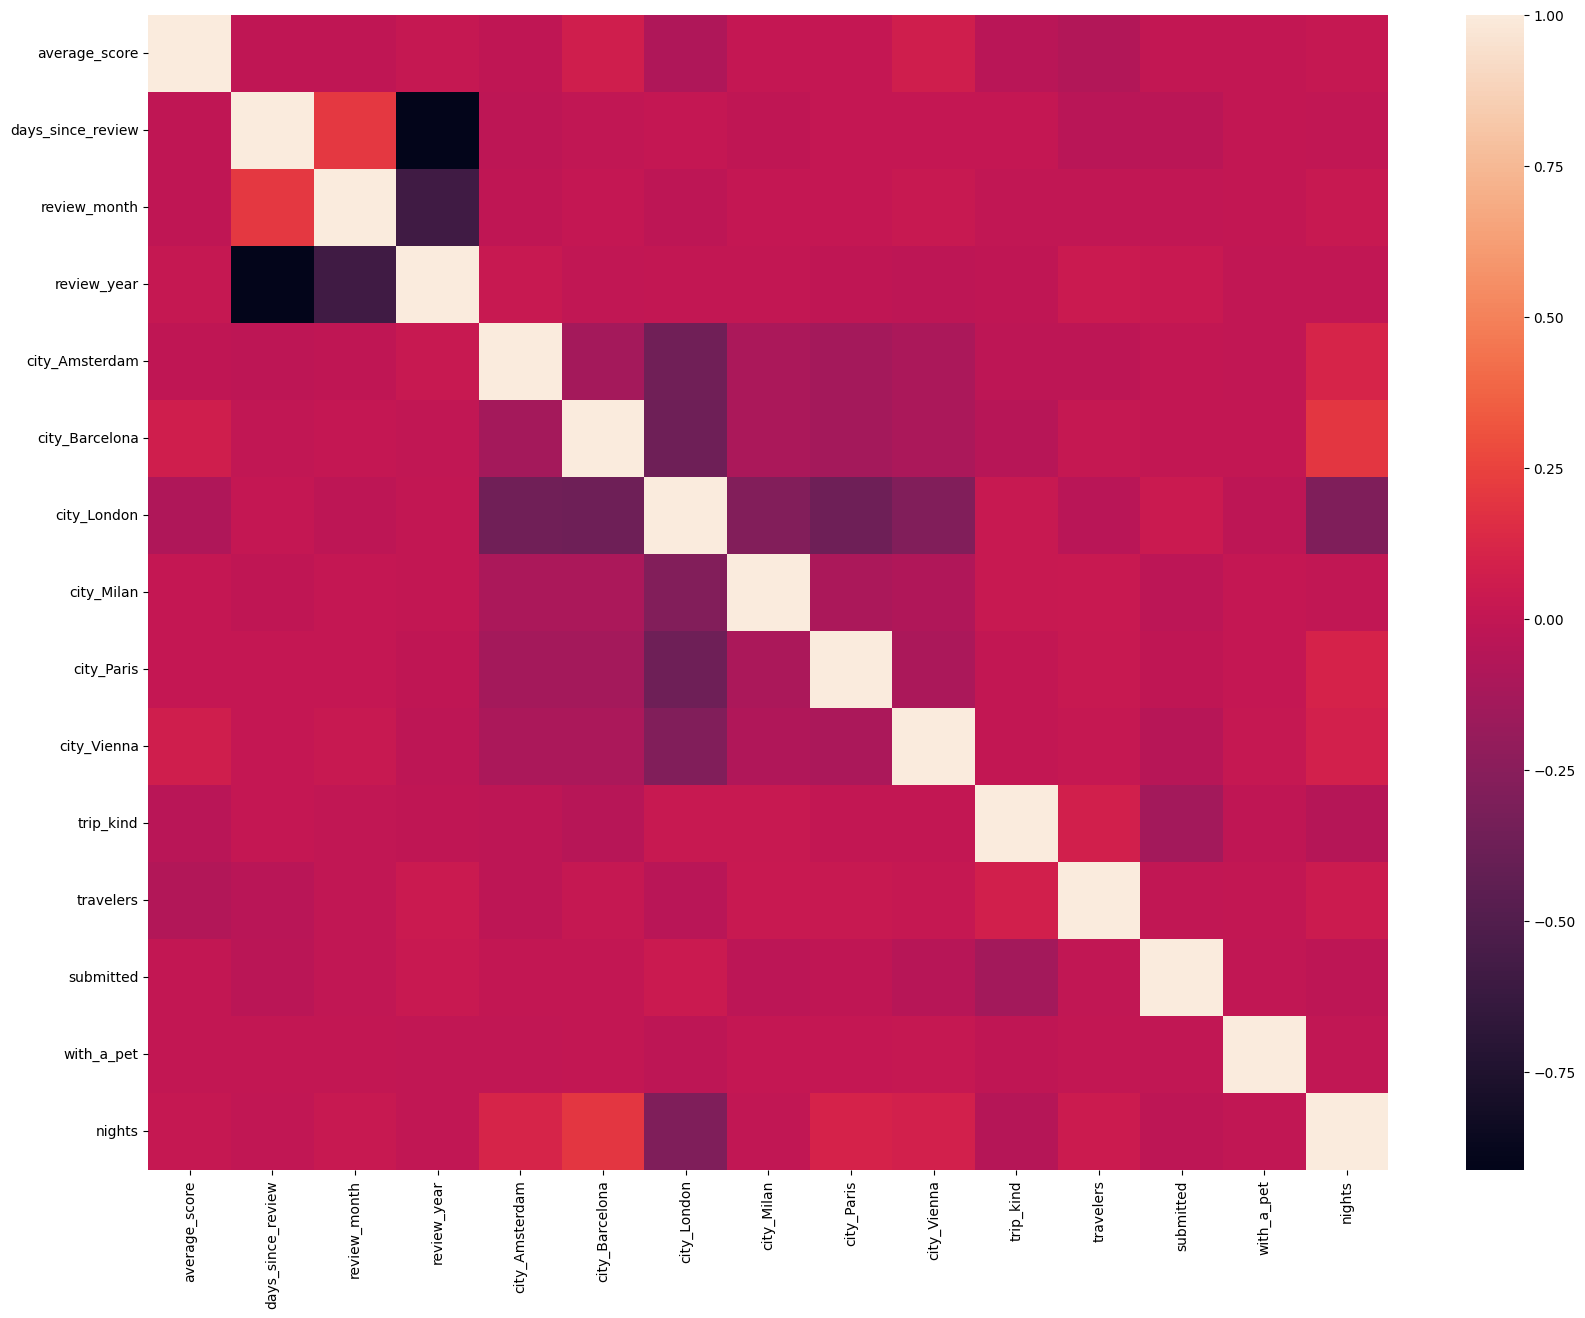

In [38]:
plt.figure(figsize=(20,15))
sns.heatmap(df[cat_cols].corr(method='spearman'),annot=False)

In [39]:
# Фильтрация признаков
#print(data.columns)
imp_num_cols = imp_num.sort_values(ascending=False).iloc[:].index
imp_cat_cols = imp_cat.sort_values(ascending=False).iloc[:].index
del_cols = 'trip_kind'
cols_for_model = ['reviewer_score','sample']
cols_for_model.extend(imp_num_cols)
cols_for_model.extend(imp_cat_cols)
cols_for_model.remove(del_cols)
cols_for_model
data = df[cols_for_model]

In [40]:
data.head(15)

,reviewer_score,sample,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,total_number_of_reviews,additional_number_of_scoring,lng,lat,days_since_review,...,city_London,nights,city_Barcelona,city_Vienna,travelers,city_Amsterdam,city_Milan,city_Paris,with_a_pet,review_year
0,10.0,1,3,-0.631735,7,1994,581,-0.143671,51.507894,531,...,True,2,False,False,1,False,False,False,0,2016
1,6.3,1,3,-0.723435,14,1361,299,-0.123097,51.521009,203,...,True,1,False,False,1,False,False,False,0,2017
2,7.5,1,6,-0.815136,14,406,32,2.325643,48.845377,289,...,False,3,False,False,2,False,False,True,0,2016
3,10.0,1,0,-0.310782,8,607,34,2.394540,48.888697,681,...,False,1,False,False,2,False,False,True,0,2015
4,9.6,1,4,0.101871,10,7586,914,4.847060,52.385601,516,...,False,6,False,False,1,True,False,False,0,2016
5,10.0,1,2,-0.081531,1,1607,105,9.257046,45.448188,582,...,False,1,False,False,2,False,True,False,0,2015
6,9.6,1,6,0.514524,4,3867,854,-0.185114,51.494231,77,...,True,1,False,False,1,False,False,False,0,2017
7,8.3,1,40,4.090850,39,2526,227,16.354169,48.208563,192,...,False,4,False,True,1,False,False,False,0,2017
8,8.3,1,30,-0.494184,3,968,227,-0.179536,51.500198,618,...,True,1,False,False,1,False,False,False,0,2015
9,6.7,1,47,-0.815136,1,3801,843,-0.213266,51.505108,548,...,True,1,False,False,1,False,False,False,0,2016


# Моделирование 

In [41]:
# Теперь выделим тестовую и обучающую части
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)
X_test = test_data.drop(['reviewer_score'], axis=1)

In [42]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [43]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128778, 22), (386314, 22), (386314, 21), (309051, 21), (77263, 21))

In [44]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [45]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [46]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [47]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9417734881724323


<Axes: >

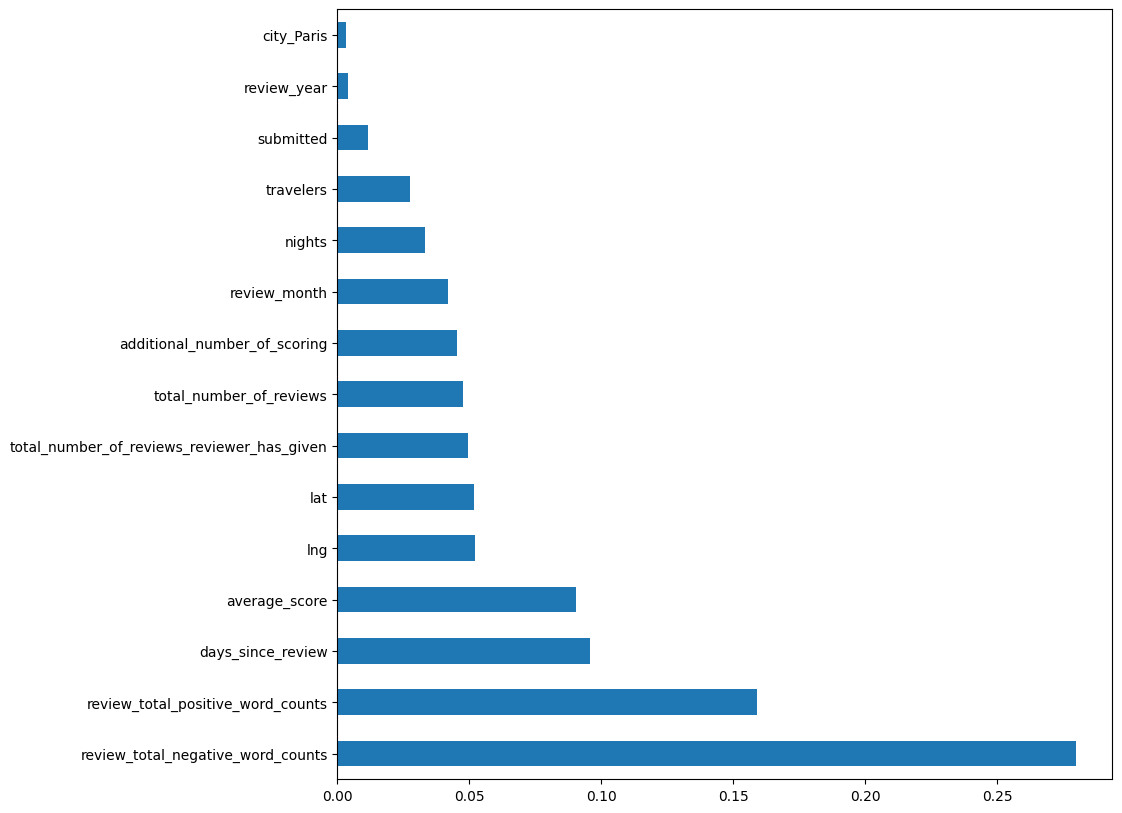

In [48]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [49]:
test_data.sample(10)

,reviewer_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,total_number_of_reviews,additional_number_of_scoring,lng,lat,days_since_review,average_score,...,city_London,nights,city_Barcelona,city_Vienna,travelers,city_Amsterdam,city_Milan,city_Paris,with_a_pet,review_year
437739,0.0,11,-0.815136,4,1592,409,-0.126012,51.506935,402,8.3,...,True,1,False,False,5,False,False,False,0,2016
450659,0.0,17,-0.540034,4,2092,368,-0.142448,51.517839,199,7.5,...,True,1,False,False,1,False,False,False,0,2017
450910,0.0,0,-0.723435,1,1116,219,-0.123298,51.528950,17,8.1,...,True,2,False,False,4,False,False,False,0,2017
440143,0.0,9,-0.677585,6,4379,420,2.141243,41.379896,109,8.6,...,False,3,True,False,4,False,False,False,0,2017
491040,0.0,2,-0.677585,1,486,75,2.293676,48.874707,372,8.9,...,False,1,False,False,1,False,False,True,0,2016
412285,0.0,0,0.560374,6,945,248,-0.007327,51.542635,345,9.2,...,True,2,False,False,1,False,False,False,0,2016
476342,0.0,102,-0.494184,6,2746,759,-0.159993,51.499968,67,7.5,...,True,3,False,False,1,False,False,False,0,2017
442256,0.0,20,-0.723435,2,948,197,4.885964,52.375875,306,9.4,...,False,1,False,False,2,True,False,False,0,2016
409512,0.0,28,-0.494184,4,2308,597,-0.157949,51.516191,663,7.9,...,True,10,False,False,3,False,False,False,0,2015
448377,0.0,88,-0.815136,1,1805,487,-0.019428,51.474469,103,8.8,...,True,1,False,False,2,False,False,False,0,2017


In [50]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [51]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [52]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished


In [53]:
predict_submission

array([8.512, 7.277, 8.257, ..., 7.775, 9.599, 6.728])

In [54]:
list(sample_submission)

['reviewer_score', 'id']

In [55]:

sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
5,10,302161
6,10,317079
7,1,13963
8,4,159785
9,10,195089
